# Reinforcement Learning 2 Q Learning

Nipun Batra  
2024-04-01

<figure>
<a
href="https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/rl-qlearning.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open In Colab</figcaption>
</figure>

Reference

1.  [Detailed Explanation and Python Implementation of Q-Learning
    Algorithm in OpenAI Gym
    (Cart-Pole)](https://www.youtube.com/watch?v=KMjQmG5Uzis)

### Basic Imports

https://www.gymlibrary.dev/environments/classic_control/mountain_car/

In [1]:
import matplotlib.pyplot as plt
import torch
import gymnasium as gym
import pandas as pd

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
env = gym.make('MountainCar-v0', render_mode='human')

In [3]:
env.reset(seed=42)
for i in range(100):
    env.render()
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(i, observation, reward, terminated, truncated, info)
    if terminated:
        break
    

0 [-0.4457913  -0.00058252] -1.0 False False {}
1 [-0.4469521  -0.00116079] -1.0 False False {}
2 [-0.44768268 -0.00073059] -1.0 False False {}
3 [-4.4797775e-01 -2.9505082e-04] -1.0 False False {}
4 [-0.4488351  -0.00085736] -1.0 False False {}
5 [-4.4924849e-01 -4.1339413e-04] -1.0 False False {}
6 [-0.4502149  -0.00096641] -1.0 False False {}
7 [-0.45072725 -0.00051235] -1.0 False False {}
8 [-0.4517818  -0.00105455] -1.0 False False {}
9 [-0.45437083 -0.00258902] -1.0 False False {}
10 [-0.45647532 -0.0021045 ] -1.0 False False {}
11 [-0.46007985 -0.00360453] -1.0 False False {}
12 [-0.4631579  -0.00307805] -1.0 False False {}
13 [-0.46568677 -0.00252887] -1.0 False False {}
14 [-0.4686478  -0.00296103] -1.0 False False {}
15 [-0.4720191 -0.0033713] -1.0 False False {}
16 [-0.47577572 -0.0037566 ] -1.0 False False {}
17 [-0.47888976 -0.00311405] -1.0 False False {}
18 [-0.4813381  -0.00244836] -1.0 False False {}
19 [-0.48410258 -0.00276447] -1.0 False False {}
20 [-0.48616257 -0.0

In [5]:
nbins_pos = 3
nbins_vel = 3

pos_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], nbins_pos)
vel_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], nbins_vel)

In [6]:
pos_bins, vel_bins

(array([-1.20000005, -0.30000001,  0.60000002]), array([-0.07,  0.  ,  0.07]))

In [7]:
# Create a Q-table in pandas with multi-index
# index in the form of (pos, vel)
# columns are the actions
n_actions = env.action_space.n


# Create labels for bins with desired format
pos_labels = [f'{pos1:.2f} < pos < {pos2:.2f}' for pos1, pos2 in zip(pos_bins[:-1], pos_bins[1:])]
vel_labels = [f'{vel1:.2f} < vel < {vel2:.2f}' for vel1, vel2 in zip(vel_bins[:-1], vel_bins[1:])]

# Create MultiIndex for the Q-table
index = pd.MultiIndex.from_product([pos_labels, vel_labels], names=['pos', 'vel'])



columns = range(n_actions)

# Create Q-table with MultiIndex
q_table = pd.DataFrame(0, index=index, columns=columns)

In [7]:
q_table

In [8]:
pos_bins

array([-1.20000005, -0.30000001,  0.60000002])

In [9]:
# adding -inft to the first and +inft to the last bin
pos_bins = np.concatenate([[-np.inf], pos_bins, [np.inf]])
vel_bins = np.concatenate([[-np.inf], vel_bins, [np.inf]])

# Create labels for bins with desired format
pos_labels = [f'{pos1:.2f} < pos < {pos2:.2f}' for pos1, pos2 in zip(pos_bins[:-1], pos_bins[1:])]
vel_labels = [f'{vel1:.2f} < vel < {vel2:.2f}' for vel1, vel2 in zip(vel_bins[:-1], vel_bins[1:])]


# Create MultiIndex for the Q-table
index = pd.MultiIndex.from_product([pos_labels, vel_labels], names=['pos', 'vel'])



columns = range(n_actions)

# Create Q-table with MultiIndex
q_table = pd.DataFrame(0, index=index, columns=columns)

In [10]:
q_table

In [11]:
pos_bins[1:-1]

array([-1.20000005, -0.30000001,  0.60000002])

In [12]:
np.digitize([-1.3, -1.20, -1.1, 0.6, 5.0], pos_bins[1:-1])

array([0, 1, 1, 2, 3])

In [11]:
# Usually, we will create1a the multi-dim array in numpy

# Create a Q-table in numpy
q_table_np = np.arange(nbins_pos * nbins_vel * n_actions).reshape(nbins_pos, nbins_vel, n_actions)
print(q_table_np.shape)

(3, 3, 3)

In [12]:
q_table_np

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

In [13]:
def discretize_pos(pos):
    return np.digitize(pos, pos_bins[1:-1])

def discretize_vel(vel):
    return np.digitize(vel, vel_bins[1:-1])

from ipywidgets import interact

@interact(pos=(-1.3, 0.9, 0.01), vel=(-0.08, 0.09, 0.01))
def show_discretize(pos, vel):
    print(f"Position index {discretize_pos(pos)}, Velocity index {discretize_vel(vel)}, Value: {q_table_np[discretize_pos(pos), discretize_vel(vel)]}")


In [14]:
# Use untrained Q-table to play the game

observation,  _  = env.reset(seed=42)

for i in range(100):
    env.render()
    pos, vel = observation
    pos_idx = discretize_pos(pos)
    vel_idx = discretize_vel(vel)
    action = np.argmax(q_table_np[pos_idx, vel_idx])
    observation, reward, terminated, truncated, info = env.step(action)
    print(i, observation, reward, terminated, truncated, info, action)
    if terminated:
        break
    

0 [-4.4479132e-01  4.1747934e-04] -1.0 False False {} 2
1 [-0.4439594   0.00083191] -1.0 False False {} 2
2 [-0.4427191   0.00124029] -1.0 False False {} 2
3 [-0.4410795   0.00163962] -1.0 False False {} 2
4 [-0.43905246  0.00202703] -1.0 False False {} 2
5 [-0.43665275  0.00239971] -1.0 False False {} 2
6 [-0.43389776  0.00275498] -1.0 False False {} 2
7 [-0.43080744  0.00309032] -1.0 False False {} 2
8 [-0.4274041   0.00340333] -1.0 False False {} 2
9 [-0.42371225  0.00369185] -1.0 False False {} 2
10 [-0.4197584   0.00395386] -1.0 False False {} 2
11 [-0.41557083  0.00418759] -1.0 False False {} 2
12 [-0.41117933  0.00439149] -1.0 False False {} 2
13 [-0.40661508  0.00456424] -1.0 False False {} 2
14 [-0.40191033  0.00470476] -1.0 False False {} 2
15 [-0.3970981   0.00481224] -1.0 False False {} 2
16 [-0.392212    0.00488609] -1.0 False False {} 2
17 [-0.38728598  0.00492601] -1.0 False False {} 2
18 [-0.38235408  0.00493192] -1.0 False False {} 2
19 [-0.37745008  0.004904  ] -1.0 F

In [33]:
# Train the Q-table

# Hyperparameters
alpha = 0.2 # learning rate
gamma = 0.99 # discount factor

# Exploration settings
epsilon = 0.8 # exploration rate

# Number of episodes
n_episodes = 4000

# Number of steps per episode
n_steps = 200

# Create a Q-table in numpy
nbins_pos = 25
nbins_vel = 25

pos_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], nbins_pos)
vel_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], nbins_vel)

pos_bins = np.concatenate([[-np.inf], pos_bins, [np.inf]])
vel_bins = np.concatenate([[-np.inf], vel_bins, [np.inf]])

q_table_np = np.random.randn(nbins_pos, nbins_vel, n_actions)

def discretize_pos(pos):
    return np.digitize(pos, pos_bins[1:-1])

def discretize_vel(vel):
    return np.digitize(vel, vel_bins[1:-1])
    

In [34]:
# loop
# disable rendering
env = gym.make('MountainCar-v0', render_mode=None)
rewards = np.zeros(n_episodes)
for episode in range(n_episodes):
    epsilon = epsilon * 0.98
    if episode % 100 == 0:
        print(f"Episode {episode}")
    observation, _ = env.reset(seed=episode)
    cumulative_reward = 0
    for step in range(n_steps):
        # discretize the observation
        pos, vel = observation
        pos_idx = discretize_pos(pos)
        vel_idx = discretize_vel(vel)
        
        # select the action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table_np[pos_idx, vel_idx])
        
        # take the action
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        cumulative_reward += reward
        # discretize the next observation
        next_pos, next_vel = next_observation
        next_pos_idx = discretize_pos(next_pos)
        next_vel_idx = discretize_vel(next_vel)
        
        # update the q-table
        q_table_np[pos_idx, vel_idx, action] += alpha * (reward + gamma * np.max(q_table_np[next_pos_idx, next_vel_idx]) - q_table_np[pos_idx, vel_idx, action])
        
        observation = next_observation
        # rewards update
        rewards[episode] = cumulative_reward
        
        if terminated:
            print(f"Episode {episode} terminated after {step} steps")
            break

Episode 0
Episode 100
Episode 200
Episode 300
Episode 400
Episode 500
Episode 504 terminated after 196 steps
Episode 588 terminated after 179 steps
Episode 589 terminated after 170 steps
Episode 590 terminated after 160 steps
Episode 593 terminated after 161 steps
Episode 596 terminated after 159 steps
Episode 597 terminated after 164 steps
Episode 598 terminated after 172 steps
Episode 599 terminated after 156 steps
Episode 600
Episode 601 terminated after 161 steps
Episode 613 terminated after 161 steps
Episode 615 terminated after 163 steps
Episode 620 terminated after 152 steps
Episode 628 terminated after 156 steps
Episode 630 terminated after 153 steps
Episode 631 terminated after 157 steps
Episode 632 terminated after 195 steps
Episode 633 terminated after 191 steps
Episode 634 terminated after 154 steps
Episode 635 terminated after 158 steps
Episode 636 terminated after 174 steps
Episode 637 terminated after 157 steps
Episode 638 terminated after 181 steps
Episode 700
Episode 7

In [35]:
q_table_np

array([[[-6.17936588e-01, -1.98903383e+00,  1.15120248e+00],
        [-4.53764806e-01,  1.34908758e-01, -1.07268580e+00],
        [ 6.36300619e-02, -6.49255742e-01,  3.43143288e-01],
        ...,
        [-1.47426748e+00, -1.92654619e-01, -1.01827323e+00],
        [-1.23244092e+00, -1.08382756e+00, -1.66590846e+00],
        [ 6.18682191e-01, -6.31722662e-01,  1.89562638e+00]],

       [[ 1.44884462e+00, -1.08582448e+00, -6.17532955e-01],
        [-2.60033696e-01, -1.50735907e+00, -7.36880075e-01],
        [-4.33453026e+00,  7.21930130e-01, -8.94114558e-01],
        ...,
        [ 1.39149714e+00, -4.35242186e-01, -1.44402614e+00],
        [ 1.47319582e+00, -9.81043937e-01, -1.16663769e+00],
        [ 1.54574724e-01,  2.01528043e-01, -7.87255597e-01]],

       [[-9.42959906e-01,  3.57988275e-01,  6.76234740e-02],
        [-1.75824035e-01, -3.90116835e-01,  2.22525056e+00],
        [-2.61460860e+01, -2.57651012e+01, -2.65800774e+01],
        ...,
        [-4.34968569e-01, -1.87249267e+00,

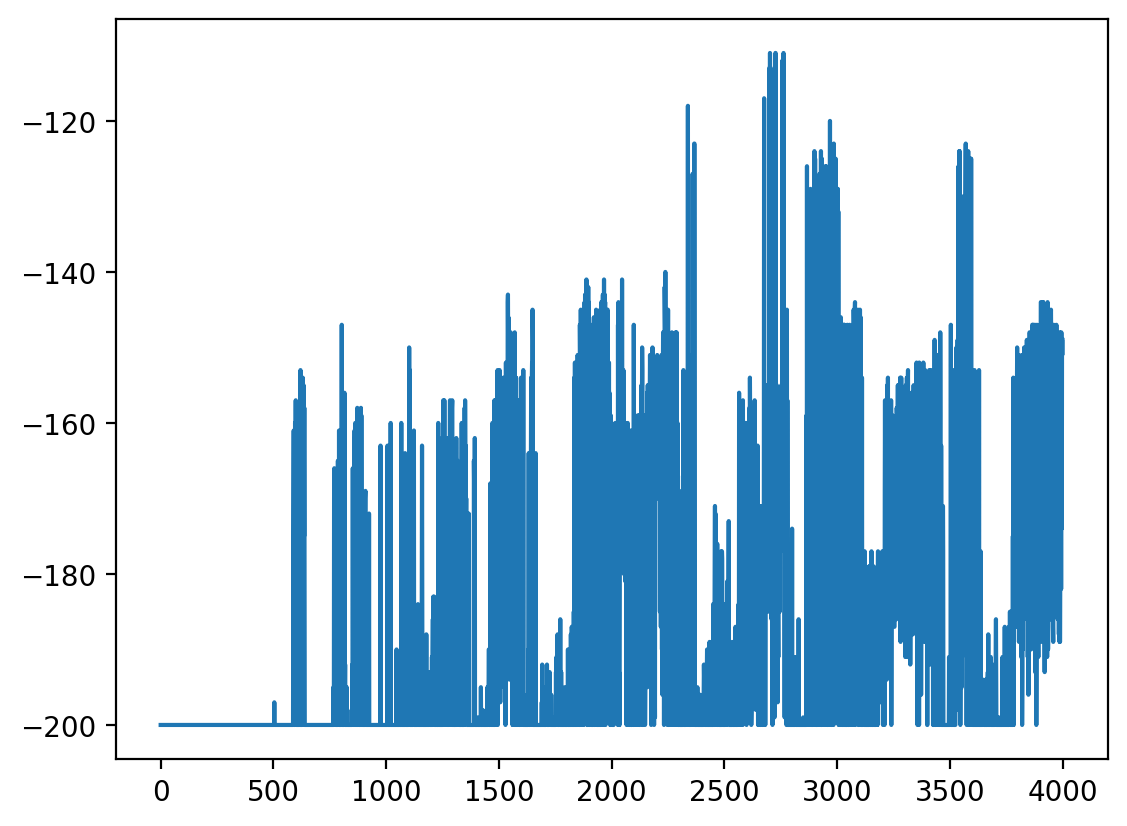

In [36]:
pd.Series(rewards).plot()

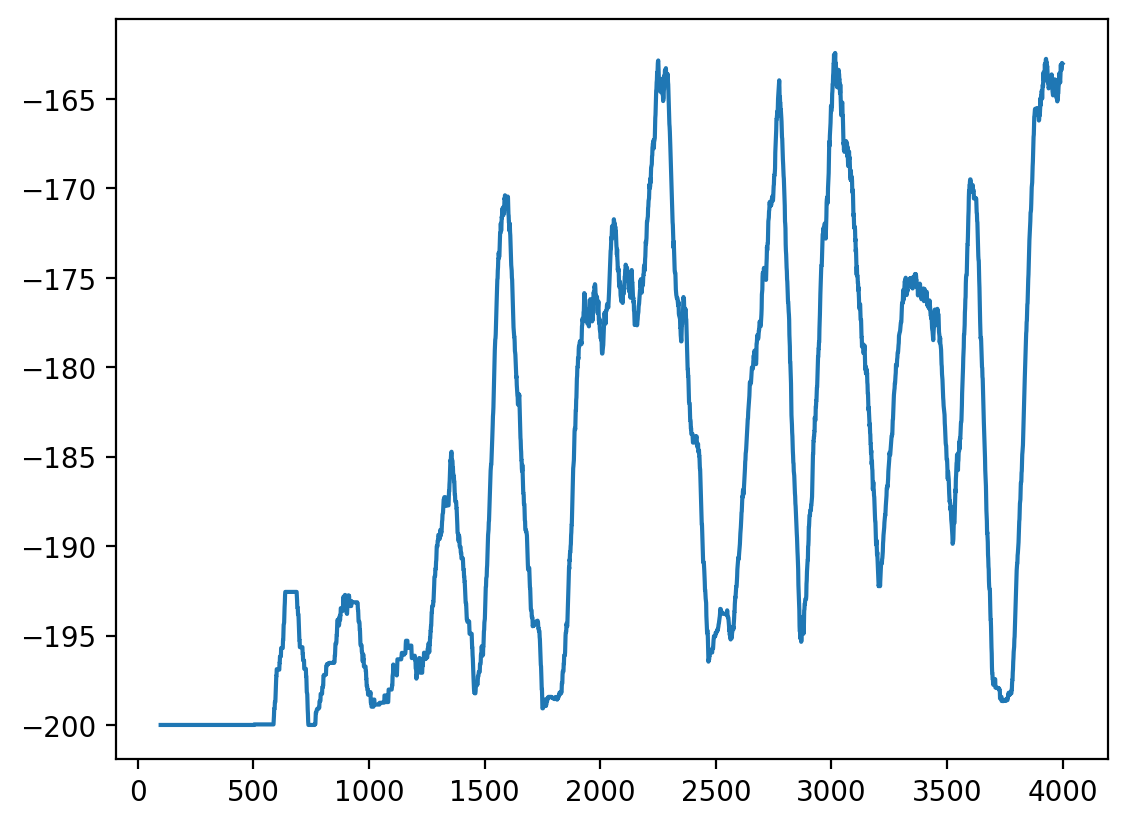

In [37]:
# plot smoothed rewards
pd.Series(rewards).rolling(100).mean().plot()

In [38]:
env = gym.make('MountainCar-v0', render_mode='human')
observation,  _  = env.reset(seed=42)

for i in range(300):
    env.render()
    pos, vel = observation
    pos_idx = discretize_pos(pos)
    vel_idx = discretize_vel(vel)
    action = np.argmax(q_table_np[pos_idx, vel_idx])
    observation, reward, terminated, truncated, info = env.step(action)
    print(i, observation, reward, terminated, truncated, info, action)
    if terminated:
        break

0 [-0.4457913  -0.00058252] -1.0 False False {} 1
1 [-0.4479521  -0.00216079] -1.0 False False {} 0
2 [-0.4516754  -0.00372328] -1.0 False False {} 0
3 [-0.45693392 -0.00525853] -1.0 False False {} 0
4 [-0.46368912 -0.00675519] -1.0 False False {} 0
5 [-0.47189122 -0.0082021 ] -1.0 False False {} 0
6 [-0.4814796  -0.00958835] -1.0 False False {} 0
7 [-0.49238297 -0.01090341] -1.0 False False {} 0
8 [-0.5045202  -0.01213718] -1.0 False False {} 0
9 [-0.5178004 -0.0132802] -1.0 False False {} 0
10 [-0.53212404 -0.01432368] -1.0 False False {} 0
11 [-0.5473838  -0.01525975] -1.0 False False {} 0
12 [-0.5634653  -0.01608151] -1.0 False False {} 0
13 [-0.58024853 -0.01678323] -1.0 False False {} 0
14 [-0.5976089 -0.0173604] -1.0 False False {} 0
15 [-0.6154188  -0.01780987] -1.0 False False {} 0
16 [-0.6335487  -0.01812989] -1.0 False False {} 0
17 [-0.6518688  -0.01832014] -1.0 False False {} 0
18 [-0.67025054 -0.01838169] -1.0 False False {} 0
19 [-0.68856746 -0.01831694] -1.0 False False

Reference: https://omarelb.github.io/dqn-investigation/

In [41]:
# Deep Q-learning


class QNetwork(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs, n_hidden=128):
        super(QNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(n_inputs, n_hidden)
        self.fc2 = torch.nn.Linear(n_hidden, n_outputs)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
n_inputs = env.observation_space.shape[0]
n_outputs = env.action_space.n

q_network = QNetwork(n_inputs, n_outputs)

In [42]:
q_network

QNetwork(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [43]:
with torch.no_grad():
    q_values = q_network(torch.tensor([0.1, 0.2], dtype=torch.float32))
    print(q_values)


tensor([-0.0065,  0.1707,  0.0062])

In [44]:
# Train the Q-network

# Hyperparameters
alpha = 0.2 # learning rate
gamma = 0.99 # discount factor

# Exploration settings
epsilon = 0.2 # exploration rate
eps_mult = 0.99

# Number of episodes
n_episodes = 2000

# Number of steps per episode
n_steps = 300



In [60]:
env = gym.make('MountainCar-v0', render_mode=None)

obs, _ = env.reset(seed=42)

q_network = QNetwork(n_inputs, n_outputs)

pos, vel = obs
pos_idx = discretize_pos(pos)
vel_idx = discretize_vel(vel)
print(observation)

with torch.no_grad():
    q_values = q_network(torch.tensor([pos, vel], dtype=torch.float32))
    print(q_values)

    action = torch.argmax(q_values).item()
    print(action)

    next_observation, reward, terminated, truncated, info = env.step(action)
    print(next_observation)

    next_pos, next_vel = next_observation

    next_pos_idx = discretize_pos(next_pos)
    next_vel_idx = discretize_vel(next_vel)

    next_q_values = q_network(torch.tensor([next_pos, next_vel], dtype=torch.float32))
    print(next_q_values)

    # Compute the target
    target = reward + gamma * torch.max(next_q_values)
    print(target)

# Compute the loss
criterion = torch.nn.MSELoss()
loss = criterion(q_values[action], target)
print(loss)




[-0.68420756 -0.01730118]
tensor([ 0.1212, -0.1776,  0.1786])
2
[-4.4479132e-01  4.1747934e-04]
tensor([ 0.1211, -0.1776,  0.1787])
tensor(-0.8231)
tensor(1.0035)

In [58]:

optimizer = torch.optim.Adam(q_network.parameters(), lr=alpha)

for episode in range(n_episodes):
    epsilon = epsilon * eps_mult
    if episode % 100 == 0:
        print(f"Episode {episode}")
    observation, _ = env.reset(seed=1)
    cumulative_reward = 0
    for step in range(n_steps):
        # discretize the observation
        pos, vel = observation
        pos_idx = discretize_pos(pos)
        vel_idx = discretize_vel(vel)
        
        # select the action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = q_network(torch.tensor([pos, vel], dtype=torch.float32))
            action = torch.argmax(q_values).item()
        
        # take the action
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        cumulative_reward += reward
        # discretize the next observation
        next_pos, next_vel = next_observation
        next_pos_idx = discretize_pos(next_pos)
        next_vel_idx = discretize_vel(next_vel)
        
        # Compute Q-values for the next state
        with torch.no_grad():
            next_q_values = q_network(torch.tensor([next_pos, next_vel], dtype=torch.float32))
            max_next_q_value = torch.max(next_q_values).item()
        
        target_q_value = reward + gamma * max_next_q_value
        
        # Compute loss and update Q-network
        q_value = q_network(torch.tensor([pos, vel], dtype=torch.float32))[action]
        criterion = torch.nn.MSELoss()
        loss = criterion(q_value, torch.tensor(target_q_value, dtype=torch.float32))
        print(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        observation = next_observation
        # rewards update
        rewards[episode] = cumulative_reward

        
        if terminated:
            print(f"Episode {episode} terminated after {step} steps")
            break

Episode 0
1.0048069953918457
1.0014567375183105
0.9958764910697937
0.9182038307189941
0.8115965723991394
0.63067626953125
0.4421957731246948
0.222701296210289
0.1335132122039795
0.03360588848590851
0.0016043486539274454
0.06032954156398773
0.10956689715385437
0.08843399584293365
0.036764971911907196
0.003027551807463169
0.006071371491998434
0.03167363628745079
0.05209045484662056
0.05149663984775543
26067.0234375
0.020529165863990784
0.019284943118691444
0.01451992616057396
0.008877977728843689
0.004237228073179722
0.001369189703837037
3689.034912109375
200.40049743652344
0.0010999157093465328
2.06069671548903e-05
0.002101067453622818
0.008885168470442295
0.019762517884373665
0.03410563990473747
0.051299456506967545
0.07075944542884827
0.09196017682552338
0.11443059146404266
0.2135302722454071
1061.5845947265625
0.35540324449539185
0.4385024905204773
2.2119390964508057
0.5501630306243896
0.6136103272438049
62.149166107177734
0.7008147239685059
0.7459989786148071
0.7844885587692261
0.81

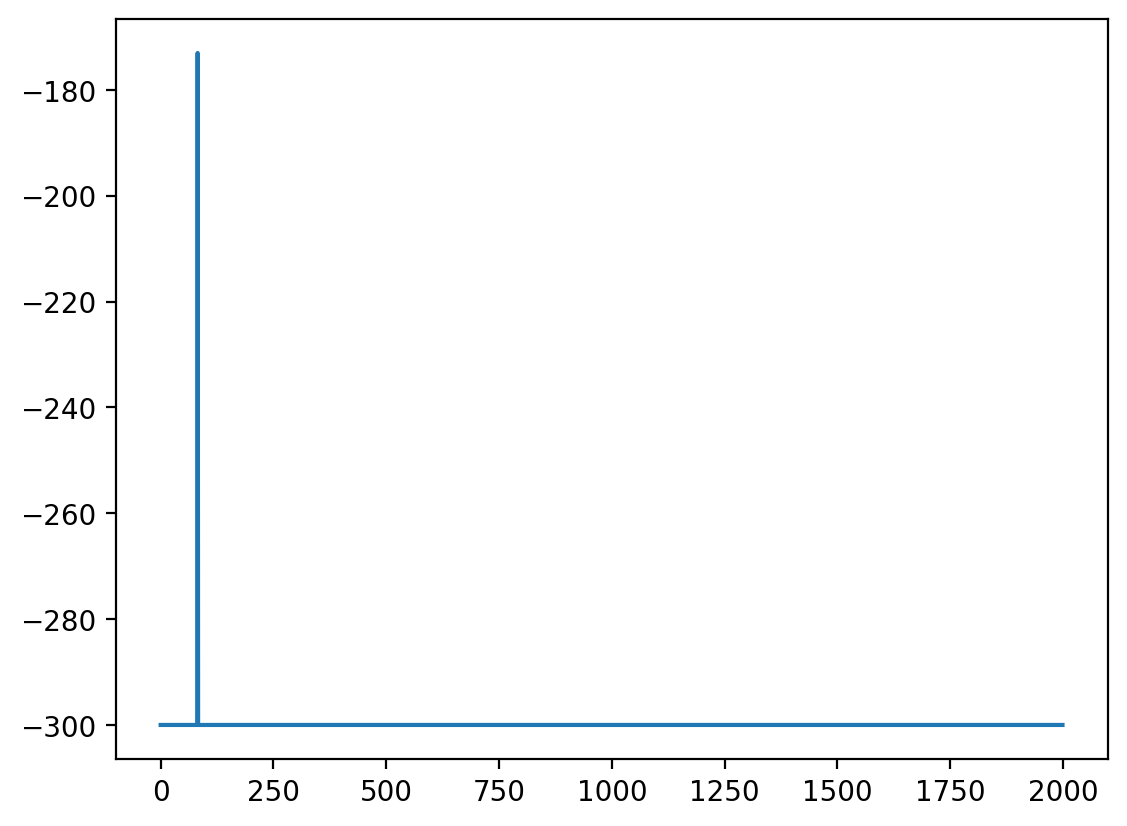

In [59]:
pd.Series(rewards).plot()

In [2]:
import flappy_bird_gymnasium
env = gym.make("FlappyBird-v0", render_mode="human", use_lidar=False)

In [3]:
obs, _ = env.reset()

In [144]:
n_bins = 16
obs_low = env.observation_space.low
obs_high = env.observation_space.high

# Discretize the observation space
def discretize_observation(observation):
    bins = np.linspace(obs_low, obs_high, n_bins)
    return tuple(np.digitize(observation, bins))

# Define the variables for the MultiIndex
variables = [
    "last_pipe_h_pos",
    "last_top_pipe_v_pos",
    "last_bottom_pipe_v_pos",
    "next_pipe_h_pos",
    "next_top_pipe_v_pos",
    "next_bottom_pipe_v_pos",
    "next_next_pipe_h_pos",
    "next_next_top_pipe_v_pos",
    "next_next_bottom_pipe_v_pos",
    "player_v_pos",
    "player_v_vel",
    "player_rotation",
]

# leave out the first three and last three variables
var_consider = variables[3:-3]


In [145]:
indices = [range(n_bins+1) for _ in var_consider] + [range(env.action_space.n)]

# Create a Q-table with a MultiIndex
q_table_np = np.random.randn(*[len(idx) for idx in indices]) * 0.2

q_table_np.shape

(17, 17, 17, 17, 17, 17, 2)

In [146]:
obs_high, obs_low

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [147]:
bins = np.linspace(obs_low[0], obs_high[0], n_bins)
bins

array([-1.        , -0.86666667, -0.73333333, -0.6       , -0.46666667,
       -0.33333333, -0.2       , -0.06666667,  0.06666667,  0.2       ,
        0.33333333,  0.46666667,  0.6       ,  0.73333333,  0.86666667,
        1.        ])

In [148]:
def discretize_observation(observation):
    bins = np.linspace(obs_low[0], obs_high[0], n_bins)
    return tuple(np.digitize(observation, bins))

obs, _ = env.reset()

print(obs[3:-3], discretize_observation(obs[3:-3]))

[1. 0. 1. 1. 0. 1.] (16, 8, 16, 16, 8, 16)

In [149]:
# Hyperparameters
alpha = 0.05 # learning rate

gamma = 0.99 # discount factor

# Exploration settings
epsilon = 1.0 # exploration rate

eps_mult = 0.99

# Number of episodes
n_episodes = 8000

# Number of steps per episode
n_steps = 500

In [150]:
# q learning loop
env = gym.make("FlappyBird-v0", render_mode=None, use_lidar=False)
rewards = np.zeros(n_episodes)

for episode in range(n_episodes):
    epsilon = epsilon * eps_mult
    if episode % 100 == 0:
        print(f"Episode {episode}")
    observation, _ = env.reset(seed=episode)
    observation = observation[3:-3]
    cumulative_reward = 0
    for step in range(n_steps):
        # discretize the observation
        obs = discretize_observation(observation)
        
        # select the action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table_np[obs])
        
        # take the action
        next_observation, reward, terminated, truncated, info = env.step(action)
        next_observation = next_observation[3:-3]
        cumulative_reward += reward
        # discretize the next observation
        next_obs = discretize_observation(next_observation)
        
        # update the q-table
        q_table_np[obs + (action,)] += alpha * (reward + gamma * np.max(q_table_np[next_obs]) - q_table_np[obs + (action,)])
        
        observation = next_observation
        # rewards update
        rewards[episode] = cumulative_reward
        
        if terminated:
            print(f"Episode {episode} terminated after {step} steps")
            break

Episode 0
Episode 0 terminated after 49 steps
Episode 1 terminated after 49 steps
Episode 2 terminated after 49 steps
Episode 3 terminated after 49 steps
Episode 4 terminated after 49 steps
Episode 5 terminated after 49 steps
Episode 6 terminated after 49 steps
Episode 7 terminated after 49 steps
Episode 8 terminated after 49 steps
Episode 9 terminated after 49 steps
Episode 10 terminated after 49 steps
Episode 11 terminated after 49 steps
Episode 12 terminated after 49 steps
Episode 13 terminated after 49 steps
Episode 14 terminated after 49 steps
Episode 15 terminated after 49 steps
Episode 16 terminated after 49 steps
Episode 17 terminated after 49 steps
Episode 18 terminated after 49 steps
Episode 19 terminated after 49 steps
Episode 20 terminated after 49 steps
Episode 21 terminated after 49 steps
Episode 22 terminated after 49 steps
Episode 23 terminated after 49 steps
Episode 24 terminated after 49 steps
Episode 25 terminated after 49 steps
Episode 26 terminated after 49 steps
E

In [151]:
epsilon

1.206581828445788e-35

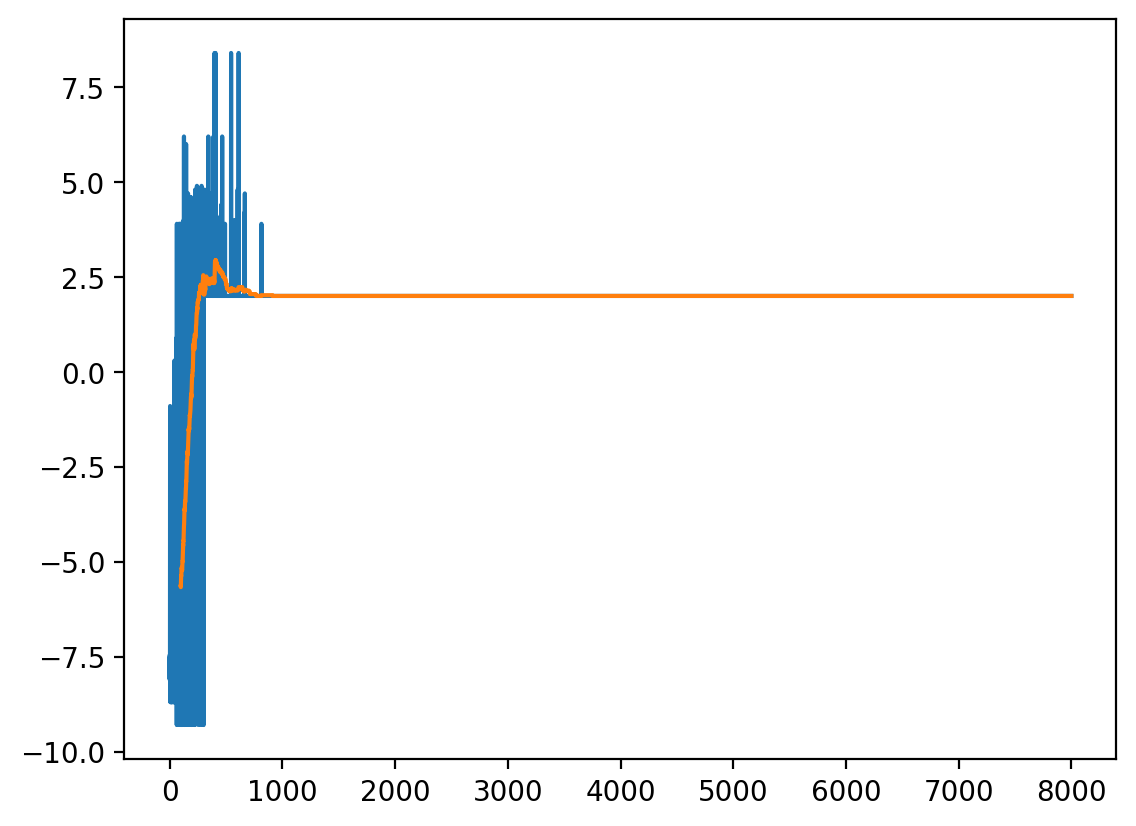

In [152]:
plt.plot(rewards)

plt.plot(pd.Series(rewards).rolling(100).mean())

In [164]:
# now play in human mode using the trained Q-table

env = gym.make("FlappyBird-v0", render_mode="human", use_lidar=False)

obs, _ = env.reset()

for i in range(300):
    env.render()
    obs = obs[3:-3]
    obs_idx = discretize_observation(obs)
    action = np.argmax(q_table_np[obs_idx])
    action = int(i%16==0)
    obs, reward, terminated, truncated, info = env.step(action)
    print(i, action)
    if terminated:
        break

0 1
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 1
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 1
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 1
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 1
65 0
66 0
67 0
68 0
69 0

In [154]:
# find mean for action


q_table_np[..., 0].mean(), q_table_np[..., 1].mean()

(-1.664908695922577e-06, -6.468030410554288e-06)